# **Neural Network**
- A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature.

## **What is PyTorch?** 
PyTorch is an optimized tensor library primarily used for Deep Learning applications using GPUs and CPUs. It is an open-source machine learning library for Python, mainly developed by the Facebook AI Research team.

### **Required Libraries**

In [472]:
import torch
import os
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import FashionMNIST
%matplotlib inline

### **downloading the FMNIST dataset**
- Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes

In [473]:
dataset = FashionMNIST(r'C:\Users\jgaur\DeepLearning', download=True)

In [474]:
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: C:\Users\jgaur\DeepLearning
    Split: Train

In [475]:
''' classes in fmnist dataset '''
classes=dataset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [476]:
''' test data '''
test_ds = FashionMNIST(r'C:\Users\jgaur\DeepLearning', train=False)

In [477]:
test_ds

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: C:\Users\jgaur\DeepLearning
    Split: Test

In [478]:
import torchvision.transforms as tt

### **Data Augmentation**
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models.

In [479]:
train_tfms = tt.Compose([
                         tt.RandomHorizontalFlip(), # it will randomly flip the images horizontaly
                         tt.RandomRotation(10), # it will rotate the image 
                         tt.ToTensor()
                        
])

val_tfms = tt.Compose([
                       tt.ToTensor()
])

In [480]:
batch_size = 128

In [481]:
train_ds = FashionMNIST(root=r'C:\Users\jgaur\DeepLearning', train=True, transform=train_tfms)
val_ds = FashionMNIST(root=r'C:\Users\jgaur\DeepLearning', train=False, transform=val_tfms)

### **loading dataset into batches**

In [482]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [483]:
image, label = dataset[0]
print(image.size)

(28, 28)


In [485]:
''' plotting some images '''
def batch_images(dl):
  for images, labels in dl:
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute(1,2,0))
    break

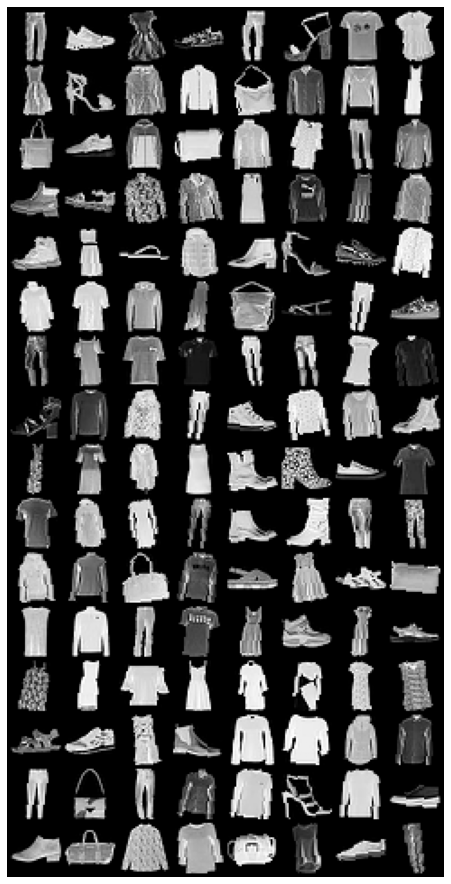

In [486]:
batch_images(train_dl)

In [489]:
''' accuracy function to calculate the accuracy '''
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### **Neural Network Model**
- The parameters of a neural network are typically the weights of the connections. In this case, these parameters are learned during the training stage. So, the algorithm itself (and the input data) tunes these parameters. The hyper parameters are typically the learning rate, the batch size or the number of epochs.

In [490]:
class FMnist(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, num_classes):
        super().__init__()
        # hidden layer
        self.layer1 = nn.Linear(in_size, 32)
        # 2nd hidden layer
        self.layer2 = nn.Linear(32, hidden_size)
        # output layer
        self.layer3 = nn.Linear(hidden_size, out_size)
        
    ''' forward propagration '''
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.reshape(-1, 784)
        # Get intermediate outputs using hidden layer
        out = self.layer1(xb)
        # Apply activation function
        out = f.relu(out)
        # Get predictions using output layer
        out = self.layer2(out)
        
        return out
    
    ''' training function '''
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = f.cross_entropy(out, labels) # Calculate loss
        return loss
    
    ''' validation function '''
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = f.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}],train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['train_loss'], result['val_loss'], result['val_acc']))

### **training of model**

In [491]:
num_classes = 10

In [492]:
''' Creating an object of class FMnist'''
model = FMnist(num_classes)

In [494]:
@torch.no_grad()
''' evalutaion step '''
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(x) for x in val_dl]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, trian_dl, val_dl, opt_func=torch.optim.Adam):
    train_loss = []
    
    ''' optimizer '''
    optimizer = opt_func(model.parameters(), lr)
    
    ''' training loop '''
    for epoch in range(epochs):
    model.train()
    for batch in train_dl:
        loss = model.training_step(batch)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    result = evaluate(model, val_dl)
    result['train_loss'] = torch.stack(train_loss).mean()
    model.epoch_end(epoch, result)
    history.append(result)
    return history

In [495]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.09824218600988388, 'val_loss': 2.301845073699951}]

In [496]:
epochs = 10
lr = 1e-4

In [497]:
history += fit(epochs, lr, model, train_dl, val_dl)

Epoch [0],train_loss: 0.8608, val_loss: 0.5702, val_acc: 0.8065
Epoch [1],train_loss: 0.6908, val_loss: 0.4738, val_acc: 0.8361
Epoch [2],train_loss: 0.6129, val_loss: 0.4311, val_acc: 0.8512
Epoch [3],train_loss: 0.5653, val_loss: 0.4008, val_acc: 0.8600
Epoch [4],train_loss: 0.5320, val_loss: 0.3862, val_acc: 0.8649
Epoch [5],train_loss: 0.5069, val_loss: 0.3808, val_acc: 0.8653
Epoch [6],train_loss: 0.4873, val_loss: 0.3642, val_acc: 0.8684
Epoch [7],train_loss: 0.4712, val_loss: 0.3504, val_acc: 0.8760
Epoch [8],train_loss: 0.4579, val_loss: 0.3436, val_acc: 0.8790
Epoch [9],train_loss: 0.4461, val_loss: 0.3420, val_acc: 0.8759


In [498]:
''' plotting loss graph '''
def plot_loss(history):
  val_loss = [x['val_loss'] for x in history]
  train_loss = [x.get('train_loss') for x in history]
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Loss vs No. of epochs")
  plt.plot(val_loss, '-xr')
  plt.plot(train_loss, '-xb')
  plt.legend("Training", "Validation")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  # Remove the CWD from sys.path while we load stuff.
/usr/lo

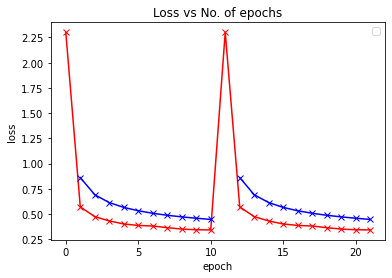

In [499]:
plot_loss(history)

In [500]:
''' plotting accuracy graph ''' 
def plot_accs(history):
  acc = [x['val_acc'] for x in history]
  plt.plot(acc, '-x')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy vs. No. of epochs")

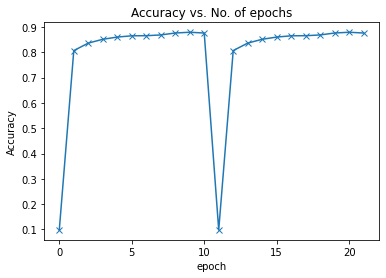

In [501]:
plot_accs(history)